# Learning and controlling a room's temperature
### Farzad Vatandoust/email: vatandoustf@gamil.com

$C\dot{T}  = K(T_a(t) - T(t))+\dot{m}_s(t) c_a (T_s(t)-T(t))+d(t)$

System output:
- $T(t)$: the room temperature at time $t$

Control parameters:
- $\dot{m}_s$: mass flow rate
- $T_s(t)$: temperature of the supply air

System parameters:
- $K$: the heat transfer coefficient
- $T_a$: the temperature outside the room at time $t$ (Constant)
- $c_a$: the specific heat capacity of air
- $d(t)$:the unknown disturbance into the room at time $t$ (Constant)
- $C$: the heat capacity of the room air,

## Section 1: Loading and analyzing the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# load dataset
dataset = pd.read_csv('data-B90102-30m.csv')
values = dataset.values
# drop unwanted data
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

                    time  room_temp  supply_temp  airflow_current
0  2021-04-26T09:37:00.0       72.3         59.3              416
1  2021-04-26T09:38:00.0       72.2         58.8              413
2  2021-04-26T09:39:00.0       72.2         58.5              419
3  2021-04-26T09:40:00.0       72.1         58.2              410
4  2021-04-26T09:41:00.0       71.9         58.1              404


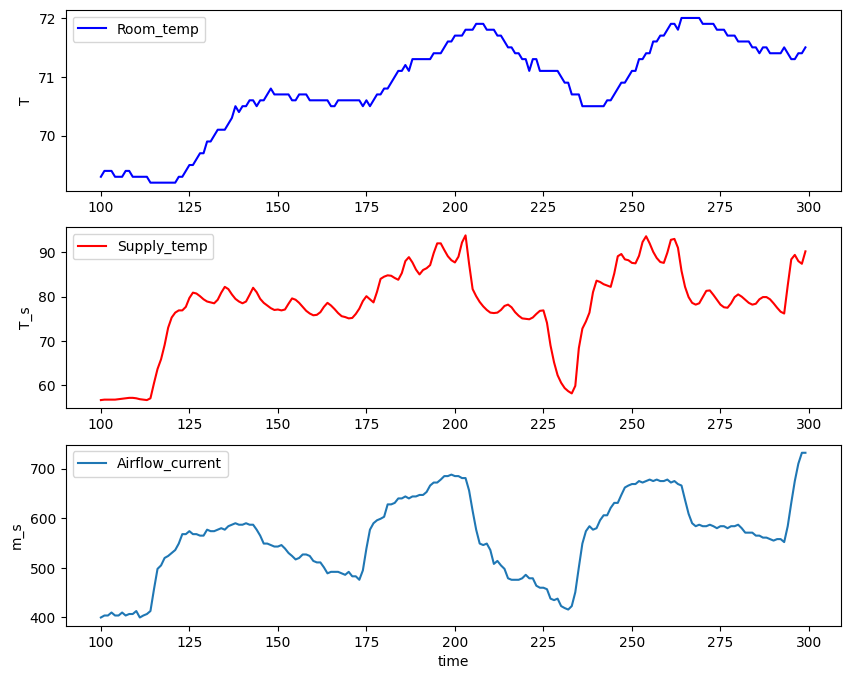

In [3]:
# plot the train data
start = 100
finish = 300
idx = np.arange(start, finish, 1)
fig = plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(idx, dataset['room_temp'][start:finish], 'b')
plt.ylabel('T')
plt.legend(["Room_temp"])

plt.subplot(3,1,2)
plt.plot(idx, dataset['supply_temp'][start:finish], 'r')
plt.ylabel('T_s')
plt.legend(["Supply_temp"])

plt.subplot(3,1,3)
plt.plot(idx, dataset['airflow_current'][start:finish])
plt.ylabel('m_s')
plt.legend(["Airflow_current"])

plt.xlabel('time')

plt.show()

### Train/Test/Validation split (Global)
Useful link https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37

In [4]:
train_nu = int(np.floor(0.7 * len(dataset)))
test_nu = int(np.floor(0.15 * len(dataset)))
val_nu = len(dataset) - train_nu - test_nu

# Section 2: Learn a differential equation model

- gekko IPOPT : https://apmonitor.com/do/index.php/Main/TCLabA (Too Slow)
- scipy odeint : classical initial value problem solver
- solve_ivp + scipy: Did not performe well in optimization
- solve_ivp + casadi(IPOPT): Lets check it out later

Load required libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import optimize
import scipy
from casadi import *


Train/Test/Validation split

In [6]:
train_data = dataset[0:train_nu]
test_data = dataset[train_nu:train_nu + test_nu]
val_data= dataset[train_nu + test_nu: ]

## 2.1 solve_ivp + scipy

Solving the intial value problem 

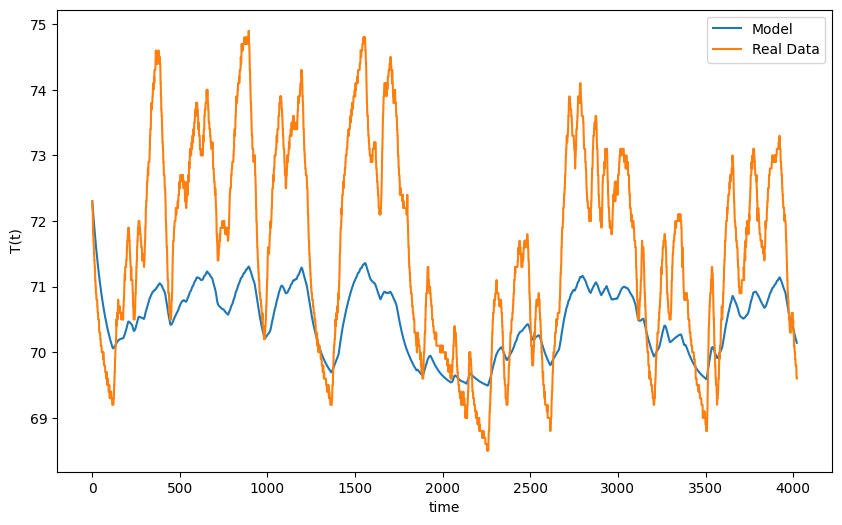

In [7]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt
    
p = np.array([50, 68.94, 0.005, 50, 4000.35])
Ts = np.array(train_data['supply_temp'])
Ms = np.array(train_data['airflow_current'])
T0 = train_data['room_temp'][0]
t = np.arange(0, train_nu, 1)
T = np.zeros(train_nu)
T[0] = T0
z0 = T0
for i in range (1, train_nu):
    ts = (t[i-1], t[i])
    # solve ODE
    z = solve_ivp(model, t_span=ts, y0=[z0],
                args=(p, Ts[i-1], Ms[i-1]))
    T[i] = z.y[0][-1]
    z0 = z.y[0][-1]

# plot results
fig = plt.figure(figsize=(10, 6))
plt.plot(t, T)
plt.plot(t, train_data['room_temp'][t])
plt.legend(["Model","Real Data"])
plt.xlabel('time')
plt.ylabel('T(t)')
plt.show()

Defining the objective function

In [8]:
def objective_func(p):
    Ts = np.array(train_data['supply_temp'])
    Ms = np.array(train_data['airflow_current'])
    T0 = train_data['room_temp'][0]
    t = np.arange(0, train_nu, 1)
    T = np.zeros(train_nu)
    T[0] = T0
    z0 = T0
    for i in range (1, train_nu):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]
           
    real = np.array(train_data['room_temp'][:train_nu])
    predicted = T
    mse = sum((real-predicted)**2)/train_nu
    return mse

Testing the objective function

In [9]:
p = np.array([10, 10, 10, 10, 1000])
objective_func(p)

172.24577883870975

Paramters estimation with optimization

In [10]:
initial_condition = ([100, 70, 2, 10, 3000])
bnds = ((0, 300),
        (30, 100),
        (0.001, 10),
        (-100, 100),
        (1000, 10000))
Nfeval = 0
def mycallback(x):
  global Nfeval
  cost = objective_func(x)
  Nfeval += 1
  print ('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}   {5: 3.6f}  {6: 3.6f}'.format(Nfeval, x[0], x[1], x[2], x[3], x[4], cost))

print('{0:4s}        {1:9s}     {2:9s}   {3:9s}   {4:9s}     {5:9s}   {6:9s}'.format('Iter', 'K', 'Ta', 'ca', ' d', 'C', 'Cost')) 
res = scipy.optimize.minimize(objective_func, initial_condition, method='SLSQP', bounds=bnds, tol=1e-6, callback=mycallback)

Iter        K             Ta          ca           d            C           Cost     


d:\Control\01-Learning and controlling a room's temperature\MPC\.venvMPC\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


   1    100.233076    69.627567    0.001000    9.996264    3000.002312   5.587486
   2    100.240352    69.753255    1.926647    9.997517    3000.002386   138.068131
   3    100.245182    70.396566    0.032337    10.003936    3000.002489   0.539807
   4    100.255982    70.618545    0.021678    10.006152    3000.002654   0.355481
   5    100.254928    70.493179    0.024531    10.004901    3000.002692   0.336025
   6    100.253572    70.495182    0.024280    10.004921    3000.002751   0.335783
   7    100.251699    70.495336    0.024269    10.004922    3000.002813   0.335779
   8    100.235684    70.495882    0.024227    10.004926    3000.003340   0.335756
   9    100.180202    70.496795    0.024145    10.004930    3000.005167   0.335693
  10    100.043086    70.497816    0.024022    10.004931    3000.009680   0.335552
  11    99.639696    70.498953    0.023781    10.004918    3000.022955   0.335160
  12    98.590955    70.499077    0.023334    10.004862    3000.057466   0.334175
  13  

In [11]:
# Julia results
p = np.array([44.79, 64.67, 0.011, 258.78, 2093.94])
a = objective_func(p)

p = np.array([62.62, 70.30, 0.017, 10.00, 3001.24])
b = objective_func(p)

print("Julia result :" + str(a))
print("Python result :" + str(b))

Julia result :0.31685806027073515
Python result :0.2908368169990662


Display the optimized model

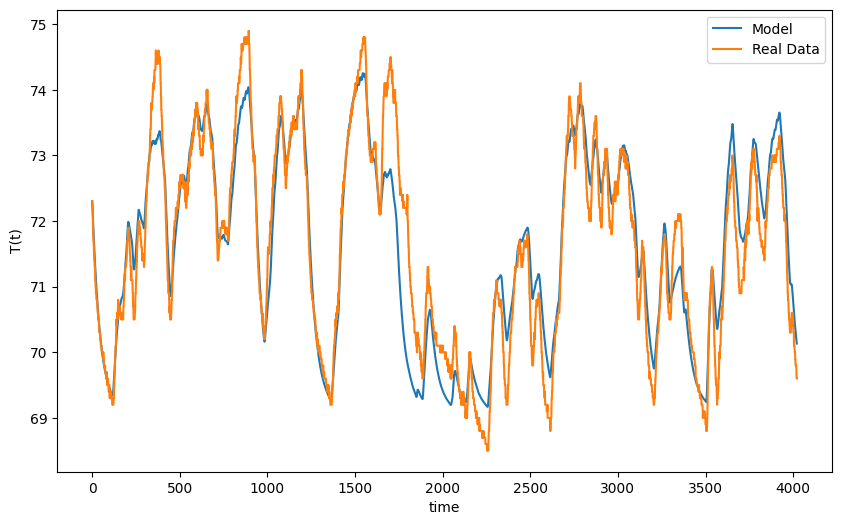

In [12]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt
    
p = res.x
Ts = np.array(train_data['supply_temp'])
Ms = np.array(train_data['airflow_current'])
T0 = train_data['room_temp'][0]
t = np.arange(0, train_nu, 1)
T = np.zeros(train_nu)
T[0] = T0
z0 = T0
for i in range (1, train_nu):
    ts = (t[i-1], t[i])
    # solve ODE
    z = solve_ivp(model, t_span=ts, y0=[z0],
                args=(p, Ts[i-1], Ms[i-1]))
    T[i] = z.y[0][-1]
    z0 = z.y[0][-1]

# plot results
fig = plt.figure(figsize=(10, 6))
plt.plot(t, T)
plt.plot(t, train_data['room_temp'][t])
plt.legend(["Model","Real Data"])
plt.xlabel('time')
plt.ylabel('T(t)')
plt.show()

## 2.2 CasADi + ipopt

In [ ]:
from casadi import *
import numpy as NP
import matplotlib.pyplot as plt
import time
from casadi.tools import *
from scipy import linalg, matrix
plt.interactive(True)

dt = 1; # Time step

# Equation patameters derived from parameters estimation
k_ep = 62.62
Ta_ep = 70.30
ca_ep = 0.017
d_ep = 10.0
C_ep = 3001.24

#states
states = struct_symSX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symSX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


rhs = struct_SX(states)
rhs["T"] = (k_ep * (Ta_ep - T) + Ms * ca_ep * (Ts - T) + d_ep) / C_ep

f = Function('f', [states,controls],[rhs])

# Build an integrator for this system: Runge Kutta 4 integrator
k1 = f(states,controls)
k2 = f(states+dt/2.0*k1,controls)
k3 = f(states+dt/2.0*k2,controls)
k4 = f(states+dt*k3,controls)
states_1 = states+dt/6.0*(k1+2*k2+2*k3+k4)
phi = Function('phi', [states,controls],[states_1])



In [ ]:

# Create tructure for the entire horizon
variables = struct_symSX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symSX([entry("x0", shape=(6, 1))])

# NPL for optimization
obj = 0
a = 1
b =0.000001
sigma = 0.00001

obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = phi(parameters["x0", 0], variables["U", 0])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = phi(parameters["x0", 0], variables["U", k])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": False, 'ipopt.max_iter':100}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)


#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0

max_delta_Ms = 65.0
min_delta_Ms = -65.0

# Soft constraints
max_Ts = 90.0
min_Ts = 55.0

max_Ms = 1000.0
min_Ms = 400.0

min_Ts_global = 55.0
min_Ms_global = 400.0

args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb

# Section 3: Learn  a Neural Network Model



## Section 3.1: LSTM via tensorflow

- Recurrent Neural Networks (RNN) by sentdex: https://www.youtube.com/watch?v=BSpXCRTOLJA&list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN&index=7
- Multivariate Time Series Forecasting with LSTMs in Keras: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- How to Convert a Time Series to a Supervised Learning Problem in Python: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Load required libraries

In [5]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [6]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv', header=0, index_col=0)
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

                       room_temp  supply_temp  airflow_current
time                                                          
2021-04-26T09:37:00.0       72.3         59.3              416
2021-04-26T09:38:00.0       72.2         58.8              413
2021-04-26T09:39:00.0       72.2         58.5              419
2021-04-26T09:40:00.0       72.1         58.2              410
2021-04-26T09:41:00.0       71.9         58.1              404


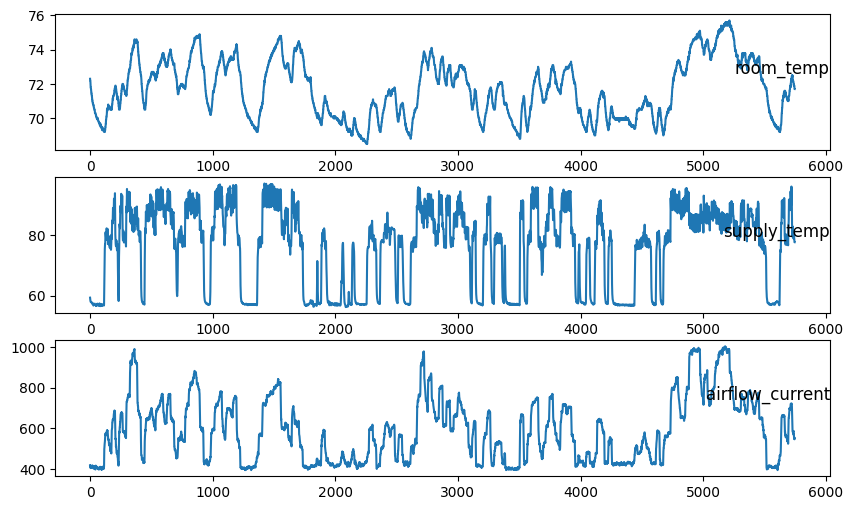

In [7]:
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
plt.figure(figsize=(10, 6))
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
plt.show()

In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
print('maximum value :' + str(scaler.data_max_))
print('minimum value :' + str(scaler.data_min_))
scaled = scaler.transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.head())

maximum value :[  75.7   97.  1003. ]
minimum value :[ 68.5  56.2 394. ]
   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.527779   0.075980   0.036125  0.513889
2   0.513889   0.063725   0.031199  0.513889
3   0.513889   0.056373   0.041051  0.500000
4   0.500000   0.049020   0.026273  0.472223
5   0.472223   0.046569   0.016420  0.458334


In [11]:
...
# split into train and test sets
values = reframed.values
train = values[0:train_nu]
test = values[train_nu:train_nu + test_nu]
validation= values[train_nu + test_nu: ]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4022, 1, 3) (4022,) (862, 1, 3) (862,)


Epoch 1/100
32/32 - 5s - loss: 0.1734 - val_loss: 0.0345 - 5s/epoch - 154ms/step
Epoch 2/100
32/32 - 0s - loss: 0.0608 - val_loss: 0.0074 - 195ms/epoch - 6ms/step
Epoch 3/100
32/32 - 0s - loss: 0.0176 - val_loss: 0.0134 - 141ms/epoch - 4ms/step
Epoch 4/100
32/32 - 0s - loss: 0.0122 - val_loss: 0.0125 - 143ms/epoch - 4ms/step
Epoch 5/100
32/32 - 0s - loss: 0.0114 - val_loss: 0.0109 - 148ms/epoch - 5ms/step
Epoch 6/100
32/32 - 0s - loss: 0.0107 - val_loss: 0.0100 - 145ms/epoch - 5ms/step
Epoch 7/100
32/32 - 0s - loss: 0.0099 - val_loss: 0.0090 - 145ms/epoch - 5ms/step
Epoch 8/100
32/32 - 0s - loss: 0.0092 - val_loss: 0.0081 - 143ms/epoch - 4ms/step
Epoch 9/100
32/32 - 0s - loss: 0.0086 - val_loss: 0.0073 - 161ms/epoch - 5ms/step
Epoch 10/100
32/32 - 0s - loss: 0.0079 - val_loss: 0.0065 - 159ms/epoch - 5ms/step
Epoch 11/100
32/32 - 0s - loss: 0.0073 - val_loss: 0.0058 - 171ms/epoch - 5ms/step
Epoch 12/100
32/32 - 0s - loss: 0.0068 - val_loss: 0.0052 - 173ms/epoch - 5ms/step
Epoch 13/100
3

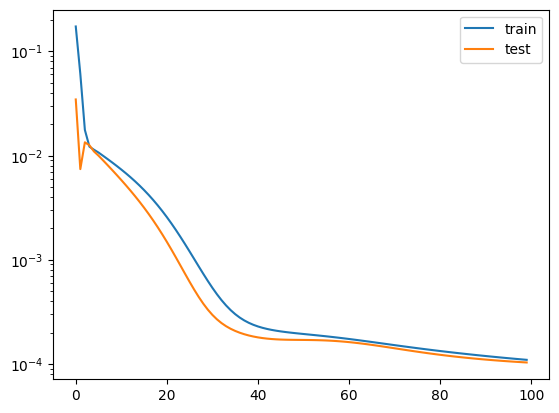

In [12]:
...
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yscale('log')
plt.show()

In [13]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

27/27 [==============================] - 1s 3ms/step
Test RMSE: 0.073


In [14]:
# Save the Model
model.save('/content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp\assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp\assets


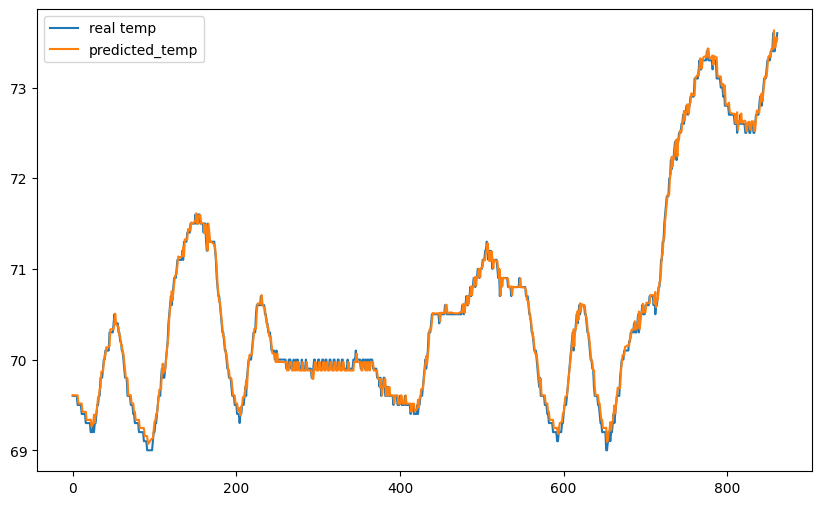

In [15]:
t = np.arange(0, len(inv_y))
plt.figure(figsize=(10, 6))
plt.plot(t, inv_y)
plt.plot(t, inv_yhat)
plt.legend(['real temp', 'predicted_temp'])
plt.show()

## Section 3.2: Pytorch

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [14]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv', header=0, index_col=0)
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

                       room_temp  supply_temp  airflow_current
time                                                          
2021-04-26T09:37:00.0       72.3         59.3              416
2021-04-26T09:38:00.0       72.2         58.8              413
2021-04-26T09:39:00.0       72.2         58.5              419
2021-04-26T09:40:00.0       72.1         58.2              410
2021-04-26T09:41:00.0       71.9         58.1              404


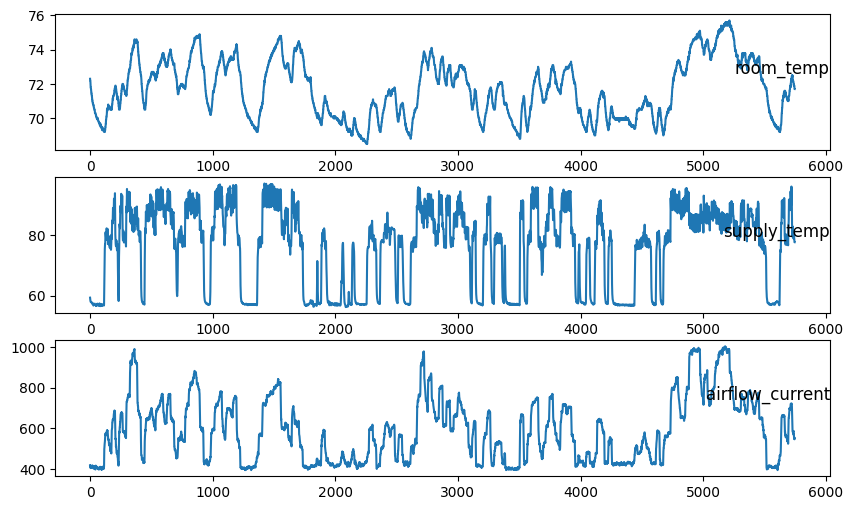

In [15]:
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
plt.figure(figsize=(10, 6))
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
plt.show()

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [17]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
print('maximum value :' + str(scaler.data_max_))
print('minimum value :' + str(scaler.data_min_))
scaled = scaler.transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.head())

maximum value :[  75.7   97.  1003. ]
minimum value :[ 68.5  56.2 394. ]
   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.527779   0.075980   0.036125  0.513889
2   0.513889   0.063725   0.031199  0.513889
3   0.513889   0.056373   0.041051  0.500000
4   0.500000   0.049020   0.026273  0.472223
5   0.472223   0.046569   0.016420  0.458334


In [38]:
...
# split into train and test sets
values = reframed.values
train = values[0:train_nu]
test = values[train_nu:train_nu + test_nu]
validation= values[train_nu + test_nu: ]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [39]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (4022, 3) (4022, 1)
Testing Shape (862, 3) (862, 1)


In [40]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [14]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [15]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4022, 1, 3]) torch.Size([4022, 1])
Testing Shape torch.Size([862, 1, 3]) torch.Size([862, 1])


In [231]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [237]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 3 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [238]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [239]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [240]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.09521
Epoch: 100, loss: 0.04610
Epoch: 200, loss: 0.04301
Epoch: 300, loss: 0.01246
Epoch: 400, loss: 0.00376
Epoch: 500, loss: 0.00206
Epoch: 600, loss: 0.00127
Epoch: 700, loss: 0.00085
Epoch: 800, loss: 0.00065
Epoch: 900, loss: 0.00050


In [241]:

X_test_tensor = Variable(torch.Tensor(X_test)) #converting to Tensors
#reshaping the dataset
X_test_tensor = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], 1, X_test_tensor.shape[1]))
train_predict = lstm1(X_test_tensor)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion

inv_data_predict = np.concatenate((data_predict, X_test[:, 1:]), axis=1)
inv_data_predict = scaler.inverse_transform(inv_data_predict)
inv_data_predict = inv_data_predict[:,0]

inv_data = np.concatenate((test_y, X_test[:, 1:]), axis=1)
inv_data = scaler.inverse_transform(inv_data)
inv_data = inv_data[:,0]

rmse = sqrt(mean_squared_error(inv_data, inv_data_predict))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.115


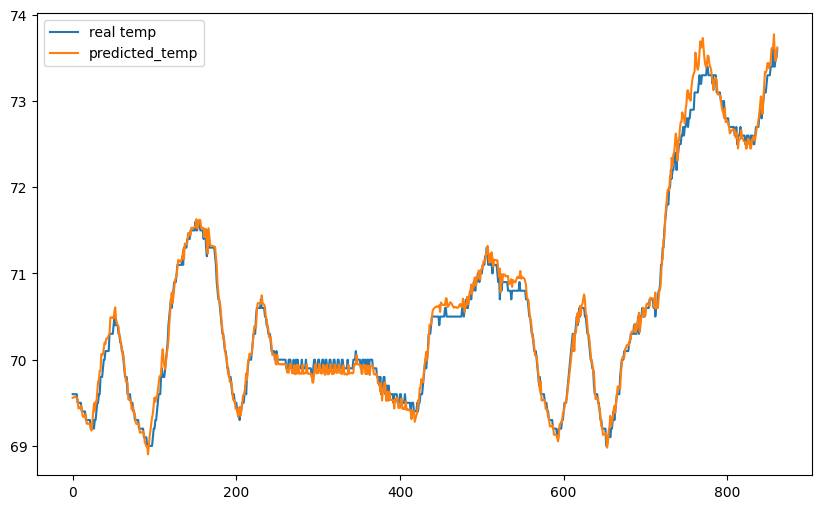

In [242]:
t = np.arange(0, len(inv_y))
plt.figure(figsize=(10, 6))
plt.plot(t, inv_data)
plt.plot(t, inv_data_predict)
plt.legend(['real temp', 'predicted_temp'])
plt.show()

In [243]:
torch.save(lstm1.state_dict(), "Pytorch_LSTM.pth")

# Section 4: MPC

- Model Predictive Control by Steve Brunton : https://www.youtube.com/watch?v=YwodGM2eoy4

- John Hedengren site: https://apmonitor.com/do/index.php/Main/TCLabG
- https://www.youtube.com/playlist?list=PLn8PRpmsu08ozoeoXgxPSBKLyd4YEHww8
- https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html
- https://github.com/gasagna/mpc
- https://yalmip.github.io/example/standardmpc/
- https://www.itk.ntnu.no/fag/TTK4135/Pensum/MPCkompendium%20HOvd.pdf
- https://www.youtube.com/watch?v=DFqOf5wbQtc

Important paper: Recurrent Neural Network-Based Model Predictive Control for Continuous Pharmaceutical Manufacturing https://www.mdpi.com/2227-7390/6/11/242/htm

- https://stackoverflow.com/questions/65720961/neural-network-mpc
- https://www.youtube.com/watch?v=uqivOJVbUNY
- https://www.youtube.com/watch?v=RrnkPrcpyEA

$Objective\:function = ||yt - y|| + c * \sum(a(T_s - 55) + b(\dot{m}_s-400) $

$ Subject\:to: 55<T_s<90,\: 400<\dot{m}_s<1000\:(Soft\:constraints)
$  

$ Subject\:to:|\Delta{T_s}|<8,\: |\Delta{\dot{m}_s}|<65\:(Hard\:constraints)$

Load required libraries

In [19]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from casadi import *

## 4.1: Casadi + Equation 

      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  42.00us (  2.00us)        21
       nlp_g  |        0 (       0)  39.00us (  1.86us)        21
    nlp_grad  |        0 (       0)   6.00us (  6.00us)         1
  nlp_grad_f  |   1.00ms ( 50.00us)  52.00us (  2.60us)        20
   nlp_jac_g  |        0 (       0)  22.00us (  1.10us)        20
       total  |  35.00ms ( 35.00ms)  35.46ms ( 35.46ms)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  48.00us (  1.66us)        29
       nlp_g  |        0 (       0)  51.00us (  1.76us)        29
    nlp_grad  |        0 (       0)   4.00us (  4.00us)         1
  nlp_grad_f  |        0 (       0)  61.00us (  2.18us)        28
   nlp_jac_g  |        0 (       0)  31.00us (  1.11us)        28
       total  |  69.00ms ( 69.00ms)  68.60ms ( 68.60ms)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

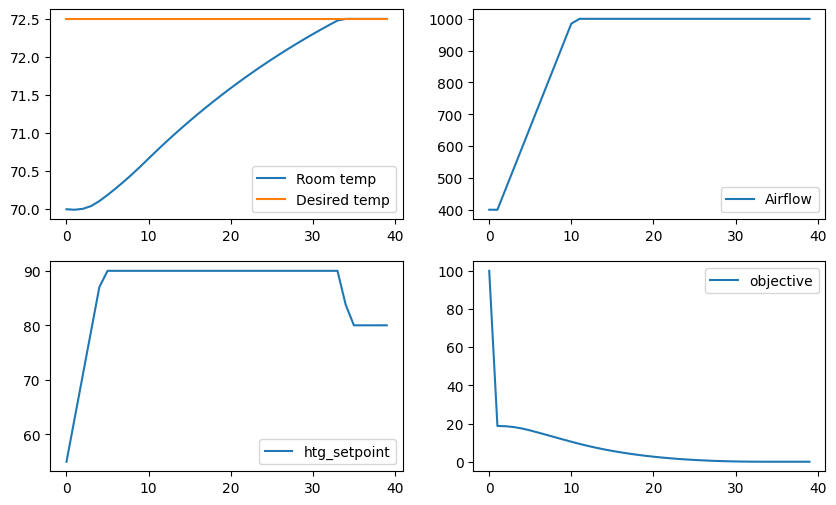

In [61]:
from casadi import *
import numpy as NP
import matplotlib.pyplot as plt
import time
from casadi.tools import *
from scipy import linalg, matrix
plt.interactive(True)

NP.random.seed(0)
N = 3 # Horizon length
runtime = 40
dt = 1; # Time step

# Equation patameters derived from parameters estimation
k_ep = 62.62
Ta_ep = 70.30
ca_ep = 0.017
d_ep = 10.0
C_ep = 3001.24

#states
states = struct_symSX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symSX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


rhs = struct_SX(states)
rhs["T"] = (k_ep * (Ta_ep - T) + Ms * ca_ep * (Ts - T) + d_ep) / C_ep

f = Function('f', [states,controls],[rhs])

# Build an integrator for this system: Runge Kutta 4 integrator
k1 = f(states,controls)
k2 = f(states+dt/2.0*k1,controls)
k3 = f(states+dt/2.0*k2,controls)
k4 = f(states+dt*k3,controls)
states_1 = states+dt/6.0*(k1+2*k2+2*k3+k4)
phi = Function('phi', [states,controls],[states_1])


# Create tructure for the entire horizon
variables = struct_symSX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symSX([entry("x0", shape=(6, 1))])

# NPL for optimization
obj = 0
a = 1
b =0.000001
sigma = 0.00001

obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = phi(parameters["x0", 0], variables["U", 0])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = phi(parameters["x0", 0], variables["U", k])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)


#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0

max_delta_Ms = 65.0
min_delta_Ms = -65.0

# Soft constraints
max_Ts = 90.0
min_Ts = 55.0

max_Ms = 1000.0
min_Ms = 400.0

min_Ts_global = 55.0
min_Ms_global = 400.0

args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb

# Lets run our simulation 
x0 = 70.0
xs = 72.5


t = np.arange(0, runtime, dt)
xxs = np.full((runtime,1), xs)
xx = []
xx.append(x0)

cost = []
cost.append(100)

TTs = []
TTs.append(min_Ts)

MMs = []
MMs.append(min_Ms)

# initial geuss for the optimization variables
mpxiter = 0

u0 = []
for i in range(N):
  u0 += [55]
  u0 += [400]


# simulate
args['x0'] = u0

for i in range(1,runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])

  # con_base = vertcat(min_Ts, min_Ms)
  st_next = phi(args['p'][0], sol['x'][0:2])

  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx)
plt.plot(t, xxs)
plt.legend(['Room temp', 'Desired temp'])

plt.subplot(2, 2, 2)
plt.plot(t, MMs)
plt.legend(['Airflow'])


plt.subplot(2, 2, 3)
plt.plot(t, TTs)
plt.legend(['htg_setpoint'])

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])

plt.show()




## 4.2 CasADi + LSTM (Keras)

### Slow  version

In [82]:
from casadi import *
from casadi.tools import *
from scipy import linalg, matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time


In [83]:
LSTM_model = keras.models.load_model("LSTM_room_temp")

In [76]:
# Callback function for evaluating LSTM

class MyCallback(Callback):
  def __init__(self, name, opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 3
  def get_n_out(self): return 1

  # Initialize the object
  def init(self):
     print('initializing object')

  # Evaluate numerically
  def eval(self, arg):
    input = np.array([arg[0], arg[1], arg[2]]).astype('float32').reshape(1,-1)
    input_reframed = input.reshape((input.shape[0], 1, input.shape[1]))
    f = LSTM_model(input_reframed)
    return [f.numpy()[0, 0]]

In [79]:
def normal(x, min, max):
    norm = (x - min)/(max - min)
    return norm

def revnormal(x, min, max):
    norm = (x * (max - min)) + min
    return norm

def normaldelta(x, min, max):
    norm = (x)/(max - min)
    return norm

In [81]:
lstm = MyCallback('lstm', {"enable_fd":True})

T = 70
Ts = 90
Ms = 1000
T = normal(T, scaler.data_min_[0],  scaler.data_max_[0])
Ts = normal(Ts, scaler.data_min_[1],  scaler.data_max_[1])
Ms = normal(Ms, scaler.data_min_[2],  scaler.data_max_[2])

To = revnormal(lstm(T, Ts, Ms), scaler.data_min_[0],  scaler.data_max_[0])
To

initializing object


DM(70.162)

In [84]:
runtime = 40
N = 3 # Horizon length
dt = 1; # Time step
obj = 0
a = 1
b =0.000001
sigma = 0.00001
#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0


max_delta_Ms = 65.0
min_delta_Ms = -65.0


# Soft constraints
max_Ts = 90.0
min_Ts = 55.0


max_Ms = 1000.0
min_Ms = 400.0


min_Ts_global = min_Ts
min_Ms_global = min_Ms

# Lets run our simulation ********
x0 = 70.0
xs = 72.5


#Normalize our data
max_delta_Ts = normaldelta(max_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_delta_Ts = normaldelta(min_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_delta_Ms = normaldelta(max_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_delta_Ms = normaldelta(min_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])


max_Ts = normal(max_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_Ts = normal(min_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_Ms = normal(max_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_Ms = normal(min_Ms, scaler.data_min_[2],  scaler.data_max_[2])

min_Ts_global = min_Ts
min_Ms_global = min_Ms

x0 = normal(x0, scaler.data_min_[0],  scaler.data_max_[0])
xs = normal(xs, scaler.data_min_[0],  scaler.data_max_[0])

#states
states = struct_symMX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symMX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


# Create tructure for the entire horizon
variables = struct_symMX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symMX([entry("x0", shape=(6, 1))])

# NPL for optimization


obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = lstm(parameters["x0", 0], variables["U", 0][0], variables["U", 0][1])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = lstm(parameters["x0", 0], variables["U", k][0], variables["U", k][1])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)




args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb


t = np.arange(0, runtime, dt)
xxs = np.full((runtime, 1), xs)
xx = []
xx.append(x0)

cost = []
cost.append(0)

TTs = []
TTs.append(min_Ts)

MMs = []
MMs.append(min_Ms)

# initial geuss for the optimization variables
mpxiter = 0

#************** 
u0 = []
for i in range(N):
  u0 += [min_Ts]
  u0 += [min_Ms]


# simulate
args['x0'] = u0

for i in range(1, runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])


  st_next = lstm(args['p'][0], sol['x'][0], sol['x'][1])
  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])


      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   9.84 s ( 17.36ms)   9.83 s ( 17.34ms)       567
       nlp_g  |   3.00ms (  5.29us)   3.70ms (  6.53us)       567
    nlp_grad  | 460.00ms (460.00ms) 460.64ms (460.64ms)         1
  nlp_grad_f  |  12.30 s (241.10ms)  12.30 s (241.14ms)        51
   nlp_jac_g  |        0 (       0) 664.00us ( 13.02us)        51
       total  |  22.88 s ( 22.88 s)  22.88 s ( 22.88 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  17.53 s ( 17.12ms)  17.51 s ( 17.10ms)      1024
       nlp_g  |   9.00ms (  8.79us)   6.58ms (  6.42us)      1024
    nlp_grad  | 454.00ms (454.00ms) 453.89ms (453.89ms)         1
  nlp_grad_f  |  24.40 s (239.17ms)  24.40 s (239.19ms)       102
   nlp_jac_g  |   1.00ms (  9.80us)   1.38ms ( 13.56us)       102
       total  |  42.93 s ( 42.93 s)  42.93 s ( 42.93 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

In [86]:
# Reverse the normalization
xx_rev = revnormal(np.array(xx), scaler.data_min_[0],  scaler.data_max_[0])
xxs_rev = revnormal(np.array(xxs), scaler.data_min_[0],  scaler.data_max_[0])
TTs_rev = revnormal(np.array(TTs), scaler.data_min_[1],  scaler.data_max_[1])
MMs_rev = revnormal(np.array(MMs), scaler.data_min_[2],  scaler.data_max_[2])

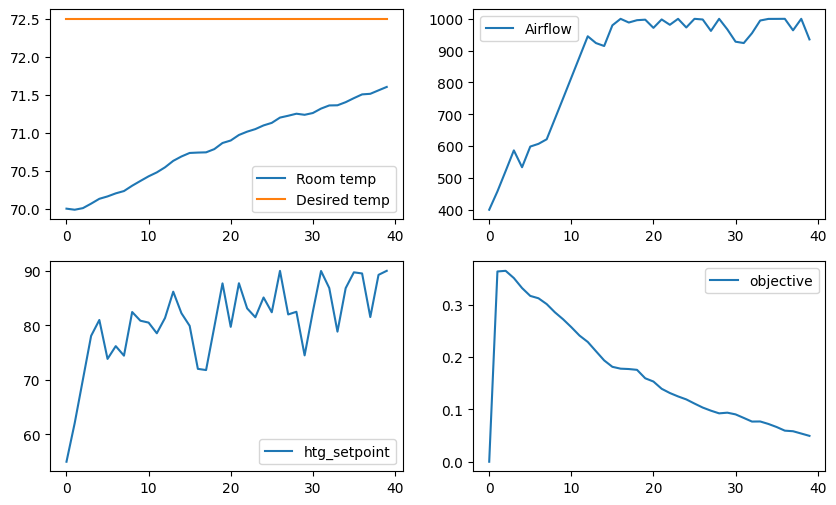

In [87]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx_rev)
plt.plot(t, xxs_rev)
plt.legend(['Room temp', 'Desired temp'])

plt.subplot(2, 2, 2)
plt.plot(t, MMs_rev)
plt.legend(['Airflow'])


plt.subplot(2, 2, 3)
plt.plot(t, TTs_rev)
plt.legend(['htg_setpoint'])

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])

plt.show()

### Fast Version
- https://www.activestate.com/resources/quick-reads/how-to-create-a-neural-network-in-python-with-and-without-keras/
- https://web.casadi.org/blog/tensorflow/
- Introduction of CasADi https://www.youtube.com/watch?v=JC6PNjndQ_c&t=61s


## 4.3 CasADi + LSTM (PyTorch)

-https://arxiv.org/pdf/2203.07747.pdf

In [88]:
from casadi import *
from casadi.tools import *
from scipy import linalg, matrix
import pandas as pd

import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

import numpy as np
import time


In [89]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [90]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 3 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [91]:

loaded_lstm = LSTM1(num_classes, input_size, hidden_size, num_layers, input_size)
loaded_lstm.load_state_dict(torch.load("Pytorch_LSTM.pth"))
loaded_lstm.eval()

LSTM1(
  (lstm): LSTM(3, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [92]:
class MyCallback(Callback):
  def __init__(self, name, opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 3
  def get_n_out(self): return 1

  # Initialize the object
  def init(self):
     print('initializing object')

  # Evaluate numerically
  def eval(self, arg):
    T = arg[0]
    Ts = arg[1]
    Ms = arg[2]
    input = np.array([T, Ts, Ms]).astype('float32').reshape(1,-1)
    input_tensor = Variable(torch.Tensor(input)) 
    input_tensor = torch.reshape(input_tensor, (input_tensor.shape[0], 1, input_tensor.shape[1]))
    output = loaded_lstm(input_tensor)
    output = output.detach().numpy()
    return [output]

In [93]:
def normal(x, min, max):
    norm = (x - min)/(max - min)
    return norm

def revnormal(x, min, max):
    norm = (x * (max - min)) + min
    return norm

def normaldelta(x, min, max):
    norm = (x)/(max - min)
    return norm

In [94]:
lstm = MyCallback('lstm', {"enable_fd":True})
T = 70
Ts = 90
Ms = 1000
T = normal(T, scaler.data_min_[0],  scaler.data_max_[0])
Ts = normal(Ts, scaler.data_min_[1],  scaler.data_max_[1])
Ms = normal(Ms, scaler.data_min_[2],  scaler.data_max_[2])

To = revnormal(lstm(T, Ts, Ms), scaler.data_min_[0],  scaler.data_max_[0])
To

initializing object


DM(70.0667)

In [95]:

runtime = 40
N = 3 # Horizon length
dt = 1; # Time step
obj = 0
a = 1
b =0.000001
sigma = 0.00001
#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0


max_delta_Ms = 65.0
min_delta_Ms = -65.0


# Soft constraints
max_Ts = 90.0
min_Ts = 55.0


max_Ms = 1000.0
min_Ms = 400.0


min_Ts_global = min_Ts
min_Ms_global = min_Ms

# Lets run our simulation ********
x0 = 70.0
xs = 72.5


#Normalize our data
max_delta_Ts = normaldelta(max_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_delta_Ts = normaldelta(min_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_delta_Ms = normaldelta(max_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_delta_Ms = normaldelta(min_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])


max_Ts = normal(max_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_Ts = normal(min_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_Ms = normal(max_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_Ms = normal(min_Ms, scaler.data_min_[2],  scaler.data_max_[2])

min_Ts_global = min_Ts
min_Ms_global = min_Ms

x0 = normal(x0, scaler.data_min_[0],  scaler.data_max_[0])
xs = normal(xs, scaler.data_min_[0],  scaler.data_max_[0])

#states
states = struct_symMX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symMX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


# Create tructure for the entire horizon
variables = struct_symMX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symMX([entry("x0", shape=(6, 1))])

# NPL for optimization


obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = lstm(parameters["x0", 0], variables["U", 0][0], variables["U", 0][1])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = lstm(parameters["x0", 0], variables["U", k][0], variables["U", k][1])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)




args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb


t = np.arange(0, runtime, dt)
xxs = np.full((runtime, 1), xs)
xx = []
xx.append(x0)

cost = []
cost.append(0)

TTs = []
TTs.append(min_Ts)

MMs = []
MMs.append(min_Ms)

# initial geuss for the optimization variables
mpxiter = 0

#************** 
u0 = []
for i in range(N):
  u0 += [min_Ts]
  u0 += [min_Ms]


# simulate
args['x0'] = u0

for i in range(1, runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])


  st_next = lstm(args['p'][0], sol['x'][0], sol['x'][1])
  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])



      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.02 s (  1.65ms)   2.04 s (  1.67ms)      1225
       nlp_g  |  11.00ms (  8.98us)   7.86ms (  6.42us)      1225
    nlp_grad  |  48.00ms ( 48.00ms)  48.19ms ( 48.19ms)         1
  nlp_grad_f  |   2.33 s ( 22.86ms)   2.34 s ( 22.90ms)       102
   nlp_jac_g  |   3.00ms ( 29.41us)   1.51ms ( 14.82us)       102
       total  |   5.09 s (  5.09 s)   5.09 s (  5.09 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.04 s (  1.56ms)   2.05 s (  1.56ms)      1313
       nlp_g  |   6.00ms (  4.57us)   6.58ms (  5.01us)      1313
    nlp_grad  |  35.00ms ( 35.00ms)  35.32ms ( 35.32ms)         1
  nlp_grad_f  |   2.24 s ( 21.97ms)   2.24 s ( 21.98ms)       102
   nlp_jac_g  |        0 (       0)   1.40ms ( 13.74us)       102
       total  |   5.05 s (  5.05 s)   5.05 s (  5.05 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

In [96]:
# Reverse the normalization
xx_rev = revnormal(np.array(xx), scaler.data_min_[0],  scaler.data_max_[0])
xxs_rev = revnormal(np.array(xxs), scaler.data_min_[0],  scaler.data_max_[0])
TTs_rev = revnormal(np.array(TTs), scaler.data_min_[1],  scaler.data_max_[1])
MMs_rev = revnormal(np.array(MMs), scaler.data_min_[2],  scaler.data_max_[2])

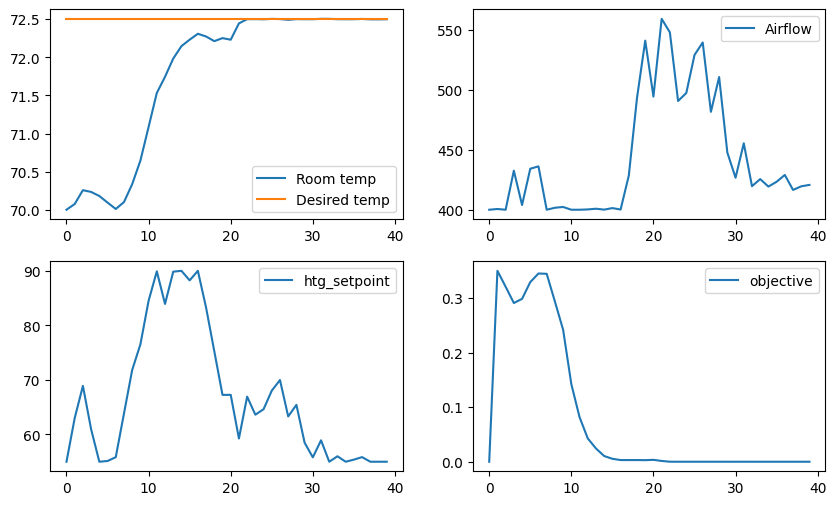

In [97]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx_rev)
plt.plot(t, xxs_rev)
plt.legend(['Room temp', 'Desired temp'])

plt.subplot(2, 2, 2)
plt.plot(t, MMs_rev)
plt.legend(['Airflow'])


plt.subplot(2, 2, 3)
plt.plot(t, TTs_rev)
plt.legend(['htg_setpoint'])

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])

plt.show()